In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf

# Read in input files

In [2]:
#Ecoli information
ecoli_df = pd.read_csv('../Data/ecoli_info/current_ecoli_master_table.tsv', sep='\t')

In [3]:
ecoli_df

,locus_tag,gene,start_loc,stop_loc,strand,cds_seq,us_seq,cds_len,well_behaved,GC_percent_cds,roc_semppr_mean,iCUB,CAI,tAI,stAIcalc,aSD_binding,sec_struct,sec_struct_bound,Start_accessibility
0,b0001,thrL,189,255,+,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,CAGATAAAAATTACAGAGTACACAACATCC,66,True,0.515152,1.244106,32.046035,0.617266,0.262286,0.258417,-2.45,NaN,NaN,NaN
1,b0002,thrA,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,2463,True,0.530654,1.034078,55.949262,0.353246,0.230564,0.216862,-5.42,-21.31,-12.81,-8.50
2,b0003,thrB,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,933,True,0.562701,0.994168,56.062386,0.357812,0.216292,0.210420,-6.51,-21.87,-14.05,-7.82
3,b0004,thrC,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,1287,True,0.528361,1.176750,53.052776,0.394675,0.231407,0.209784,-3.40,-24.44,-20.71,-3.73
4,b0005,yaaX,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,297,True,0.538721,0.837528,50.705530,0.374371,0.197715,0.208944,-6.51,-17.15,-7.38,-9.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4350,b4399,creC,4636695,4638120,+,ATGCGTATCGGCATGCGGTTGTTGCTGGGCTATTTTTTACTGGTGG...,CGGCATGGGATATAGCCTGAGGGGCCTGTA,1425,True,0.538947,0.829794,55.967103,0.293537,0.212672,0.206721,-6.09,-31.71,-18.33,-13.38
4351,b4400,creD,4638177,4639530,+,ATGTTGAAATCCCCCCTGTTCTGGAAAATGACTAGCCTGTTTGGTG...,TATCCTGCTGCCATTGCAAAGGAGAAGACT,1353,True,0.495935,0.739848,54.634345,0.288635,0.210078,0.199677,-7.00,-16.18,-10.40,-5.78
4352,b4401,arcA,4639589,4640306,-,ATGCAGACCCCGCACATTCTTATCGTTGAAGACGAGTTGGTAACAC...,TCGATTTAGTTGGCAATTTAGGTAGCAAAC,717,True,0.510460,1.676448,48.981781,0.530773,0.275348,0.239921,-2.60,-16.36,-9.19,-7.17
4353,b4402,yjjY,4640401,4640542,+,ATGACTAAAGTACGTAATTGCGTTCTTGATGCACTTTCCATCAACG...,CATGCTGCAAATTAACATGATCGGCGTAAC,141,True,0.425532,0.802032,47.451431,0.314394,0.219204,0.230201,-1.76,-14.24,-7.14,-7.10


In [4]:
#Expression data
expression_df = pd.read_csv('../Data/expression_data.csv', index_col='log-TPM')
#Expression metadata
metadata_df = pd.read_csv('../Data/expression_metadata.csv')
#Expression summary statistics
expression_summ_df = pd.read_csv('../Data/expression_summary.csv', index_col='gene')

In [5]:
#Simpler way of what is below
ecoli_df = ecoli_df[ecoli_df['locus_tag'].isin(expression_df.index)]
expression_df = expression_df[expression_df.index.isin(ecoli_df['locus_tag'])]

In [6]:
print(ecoli_df.shape)
print(expression_df.shape)

(3859, 19)
(3859, 105)


In [7]:
list(ecoli_df.sort_values('locus_tag')['locus_tag']) == list(expression_df.sort_index().index)

True

# Correlation between codon bias metrics

In [8]:
metric_df = ecoli_df[['iCUB', 'roc_semppr_mean', 'CAI', 'tAI', 'stAIcalc', 'aSD_binding', 'sec_struct', 'sec_struct_bound', 'Start_accessibility']]
metric_df

,iCUB,roc_semppr_mean,CAI,tAI,stAIcalc,aSD_binding,sec_struct,sec_struct_bound,Start_accessibility
1,55.949262,1.034078,0.353246,0.230564,0.216862,-5.42,-21.31,-12.81,-8.50
2,56.062386,0.994168,0.357812,0.216292,0.210420,-6.51,-21.87,-14.05,-7.82
3,53.052776,1.176750,0.394675,0.231407,0.209784,-3.40,-24.44,-20.71,-3.73
4,50.705530,0.837528,0.374371,0.197715,0.208944,-6.51,-17.15,-7.38,-9.77
5,53.158862,1.032499,0.353849,0.225856,0.213151,-4.00,-18.60,-8.52,-10.08
...,...,...,...,...,...,...,...,...,...
4349,54.346407,0.752851,0.275049,0.212304,0.195169,-5.13,-22.64,-14.55,-8.09
4350,55.967103,0.829794,0.293537,0.212672,0.206721,-6.09,-31.71,-18.33,-13.38
4351,54.634345,0.739848,0.288635,0.210078,0.199677,-7.00,-16.18,-10.40,-5.78
4352,48.981781,1.676448,0.530773,0.275348,0.239921,-2.60,-16.36,-9.19,-7.17


In [9]:
metric_corr = metric_df.corr(method='spearman')
metric_corr

,iCUB,roc_semppr_mean,CAI,tAI,stAIcalc,aSD_binding,sec_struct,sec_struct_bound,Start_accessibility
iCUB,1.000000,-0.515658,-0.581081,-0.538805,-0.486559,0.116562,-0.035132,0.040811,-0.106127
roc_semppr_mean,-0.515658,1.000000,0.939023,0.837262,0.546885,-0.067927,-0.046989,-0.140393,0.115631
CAI,-0.581081,0.939023,1.000000,0.843535,0.695474,-0.077340,0.030716,-0.083305,0.159779
tAI,-0.538805,0.837262,0.843535,1.000000,0.740101,-0.077043,0.038376,-0.068738,0.151971
stAIcalc,-0.486559,0.546885,0.695474,0.740101,1.000000,-0.074576,0.193054,0.074612,0.204458
aSD_binding,0.116562,-0.067927,-0.077340,-0.077043,-0.074576,1.000000,0.229129,0.075500,0.291291
sec_struct,-0.035132,-0.046989,0.030716,0.038376,0.193054,0.229129,1.000000,0.784210,0.510936
sec_struct_bound,0.040811,-0.140393,-0.083305,-0.068738,0.074612,0.075500,0.784210,1.000000,-0.068618
Start_accessibility,-0.106127,0.115631,0.159779,0.151971,0.204458,0.291291,0.510936,-0.068618,1.000000


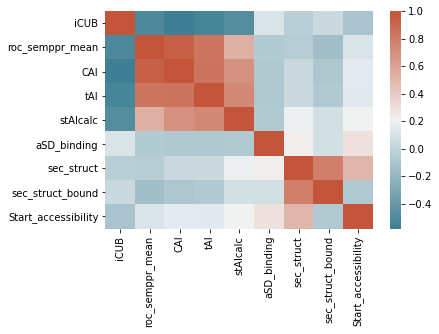

In [10]:
#Visualize correlation matrix
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(metric_corr, cmap=cmap)
plt.show()

# Correlate metrics with gene expression

In [11]:
#Combine ecoli and expression summary datasets
ecoli_df = ecoli_df.merge(expression_summ_df, left_on = 'locus_tag', right_index = True)
ecoli_df

,locus_tag,gene,start_loc,stop_loc,strand,cds_seq,us_seq,cds_len,well_behaved,GC_percent_cds,...,stAIcalc,aSD_binding,sec_struct,sec_struct_bound,Start_accessibility,average,median,max,min,growth_correlation
1,b0002,thrA,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,2463,True,0.530654,...,0.216862,-5.42,-21.31,-12.81,-8.50,10.018710,10.526692,12.379586,0.000000,0.187003
2,b0003,thrB,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,933,True,0.562701,...,0.210420,-6.51,-21.87,-14.05,-7.82,9.809393,10.119502,11.883905,7.265206,0.171581
3,b0004,thrC,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,1287,True,0.528361,...,0.209784,-3.40,-24.44,-20.71,-3.73,9.905807,10.190627,11.992770,7.371951,0.137721
4,b0005,yaaX,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,297,True,0.538721,...,0.208944,-6.51,-17.15,-7.38,-9.77,5.487261,5.727661,7.551687,1.751870,0.343497
5,b0006,yaaA,5682,6459,-,ATGCTGATTCTTATTTCACCTGCGAAAACGCTTGATTACCAAAGCC...,GTCGGCATAAATTTCCTGCAAGGACTGGAT,777,True,0.496782,...,0.213151,-4.00,-18.60,-8.52,-10.08,6.855512,6.843384,8.371287,5.285927,0.319636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4349,b4398,creB,4636006,4636696,+,ATGCAACGGGAAACGGTCTGGTTAGTGGAAGATGAGCAAGGGATAG...,ATGCCGTGGCGGCAATAACAGAGGCGATTT,690,True,0.552174,...,0.195169,-5.13,-22.64,-14.55,-8.09,6.009723,6.087211,6.904011,5.173515,0.088129
4350,b4399,creC,4636695,4638120,+,ATGCGTATCGGCATGCGGTTGTTGCTGGGCTATTTTTTACTGGTGG...,CGGCATGGGATATAGCCTGAGGGGCCTGTA,1425,True,0.538947,...,0.206721,-6.09,-31.71,-18.33,-13.38,4.678600,4.680129,5.774172,3.352289,-0.265587
4351,b4400,creD,4638177,4639530,+,ATGTTGAAATCCCCCCTGTTCTGGAAAATGACTAGCCTGTTTGGTG...,TATCCTGCTGCCATTGCAAAGGAGAAGACT,1353,True,0.495935,...,0.199677,-7.00,-16.18,-10.40,-5.78,3.301490,3.328477,4.587381,1.267809,-0.496185
4352,b4401,arcA,4639589,4640306,-,ATGCAGACCCCGCACATTCTTATCGTTGAAGACGAGTTGGTAACAC...,TCGATTTAGTTGGCAATTTAGGTAGCAAAC,717,True,0.510460,...,0.239921,-2.60,-16.36,-9.19,-7.17,10.094472,10.056122,12.256557,8.332869,-0.079162


In [12]:
def calc_metric_correlation(metric):
    #Correlation between metric and average gene expression
    avg_rho, p = stats.spearmanr(ecoli_df[metric], ecoli_df['average'])
    #Correlation between metric and median gene expression
    med_rho, p = stats.spearmanr(ecoli_df[metric], ecoli_df['median'])
    #Correlation between metric and max gene expression
    max_rho, p = stats.spearmanr(ecoli_df[metric], ecoli_df['max'])
    #Correlation between metric and min gene expression
    min_rho, p = stats.spearmanr(ecoli_df[metric], ecoli_df['min'])
    #Correlation between metric and growth correlation
    growth_rho, p = stats.spearmanr(ecoli_df[metric], ecoli_df['growth_correlation'])
    
    return [avg_rho, med_rho, max_rho, min_rho, growth_rho]

In [13]:
#Calculate each metric's correlation with gene expression data
icub_corr_list = calc_metric_correlation('iCUB')
roc_corr_list = calc_metric_correlation('roc_semppr_mean')
cai_corr_list = calc_metric_correlation('CAI')
tai_corr_list = calc_metric_correlation('tAI')
staicalc_corr_list = calc_metric_correlation('stAIcalc')
asd_corr_list = calc_metric_correlation('aSD_binding')
ss_corr_list = calc_metric_correlation('sec_struct')
ss_bound_corrr_list = calc_metric_correlation('sec_struct_bound')
accessibility_list = calc_metric_correlation('Start_accessibility')

In [14]:
#Create dataframe for bar plots
metrics_corr_df = pd.DataFrame(zip(icub_corr_list, roc_corr_list, cai_corr_list, tai_corr_list, staicalc_corr_list, asd_corr_list, ss_corr_list, ss_bound_corrr_list, accessibility_list), columns=['iCUB', 'roc_semppr_mean', 'CAI', 'tAI', 'stAIcalc', 'aSD_binding', 'sec_struct', 'sec_struct_bound', 'Start_accessibility'], index=['average', 'median', 'max', 'min', 'growth'])

In [15]:
metrics_corr_df.index.name = 'Statistic'

In [16]:
metrics_corr_df

,iCUB,roc_semppr_mean,CAI,tAI,stAIcalc,aSD_binding,sec_struct,sec_struct_bound,Start_accessibility
Statistic,,,,,,,,,
average,-0.309912,0.421809,0.440157,0.400016,0.353829,0.031918,0.023777,-0.039924,0.091711
median,-0.306284,0.406379,0.426212,0.386464,0.345093,0.035976,0.026995,-0.036393,0.091948
max,-0.342622,0.430162,0.461406,0.420198,0.400793,-0.087277,0.039778,-0.022696,0.088539
min,-0.212038,0.418298,0.410036,0.367620,0.276687,0.062718,-0.035387,-0.092919,0.072106
growth,-0.237348,0.388004,0.363922,0.324583,0.206069,0.074659,-0.057278,-0.100685,0.048217


In [17]:
#Step up in complexity before complex bar plots

<AxesSubplot:xlabel='Statistic'>

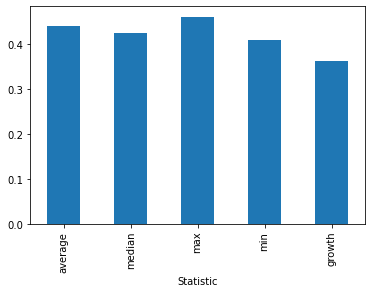

In [18]:
#Bar chart of on metric's correlation with expression summary stats
metrics_corr_df['CAI'].plot.bar(x='Metric', y='Spearman')

LinregressResult(slope=12.625167516323316, intercept=0.8616635681905214, rvalue=0.5132832314163709, pvalue=1.93473551036054e-258, stderr=0.33990184171317595)


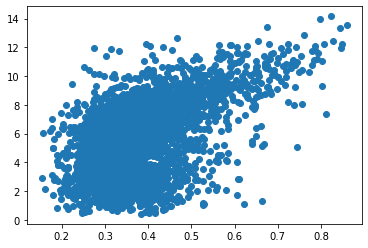

In [19]:
#Scatter plot showing the iCUB metric correlated with the average gene expression
fig, ax = plt.subplots()
ax.scatter(ecoli_df['CAI'], ecoli_df['average'])
print(stats.linregress(ecoli_df['CAI'], ecoli_df['average']))

LinregressResult(slope=12.32949017583087, intercept=3.3955562799313466, rvalue=0.5014766692554907, pvalue=6.467897145384167e-245, stderr=0.3425086980475897)


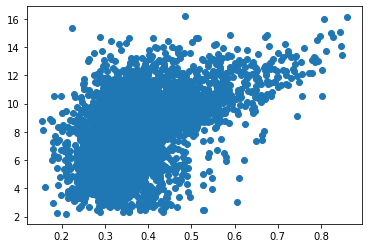

In [20]:
#Scatter plot showing the iCUB metric correlated with the max gene expression
fig, ax = plt.subplots()
ax.scatter(ecoli_df['CAI'], ecoli_df['max'])
print(stats.linregress(ecoli_df['CAI'], ecoli_df['max']))

LinregressResult(slope=1.0412190005496353, intercept=-0.48916960435919016, rvalue=0.3927734280424899, pvalue=1.5117404434676835e-142, stderr=0.03925462078457915)


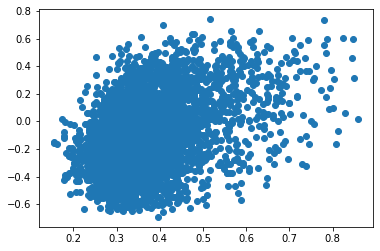

In [21]:
#Scatter plot showing the iCUB metric correlated with the max gene expression
fig, ax = plt.subplots()
ax.scatter(ecoli_df['CAI'], ecoli_df['growth_correlation'])
print(stats.linregress(ecoli_df['CAI'], ecoli_df['growth_correlation']))

<AxesSubplot:xlabel='Metric', ylabel='Spearman'>

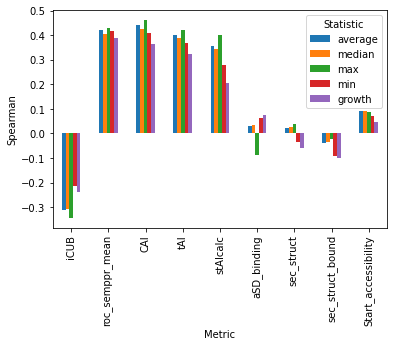

In [22]:
#Clustered bar chart of each metric's correlation with each summary statistic
metrics_corr_df.T.plot(xlabel="Metric", ylabel="Spearman", kind="bar")

# Multivariate regression analysis

In [23]:
#Average gene expression

In [24]:
#Major codon bias metrics
smf.ols('CAI ~ average', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     1380.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          1.93e-258
Time:                        11:28:56   Log-Likelihood:                 4026.0
No. Observations:                3859   AIC:                            -8048.
Df Residuals:                    3857   BIC:                            -8035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2585      0.003     75.300      0.000       0.252       0.265
average        0.0209      0.001     37.144      0.000       0.020       0.022
==============================================================================
Omnibus:                      463.142   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              728.914
Skew:                           0.850   Prob(JB):                    5.23e-159
Kurtosis:                       4.283   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
smf.ols('CAI ~ average + growth_correlation', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     859.5
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          2.00e-309
Time:                        11:28:56   Log-Likelihood:                 4147.3
No. Observations:                3859   AIC:                            -8289.
Df Residuals:                    3856   BIC:                            -8270.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2871      0.004     75.828      0.000       0.280       0.295
average                0.0173      0.001     29.309      0.000       0.016       0.018
growth_correlation     0.0866      0.005     15.820      0.000       0.076       0.097
==============================================================================
Omnibus:                      477.638   Durbin-Watson:                   1.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              777.963
Skew:                           0.855   Prob(JB):                    1.17e-169
Kurtosis:                       4.383   Cond. No.                         27.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
smf.ols('tAI ~ average', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tAI   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     872.0
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          5.86e-173
Time:                        11:28:56   Log-Likelihood:                 9036.2
No. Observations:                3859   AIC:                        -1.807e+04
Df Residuals:                    3857   BIC:                        -1.806e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2043      0.001    218.016      0.000       0.202       0.206
average        0.0045      0.000     29.529      0.000       0.004       0.005
==============================================================================
Omnibus:                       20.455   Durbin-Watson:                   1.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.573
Skew:                           0.051   Prob(JB):                     1.03e-06
Kurtosis:                       3.401   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
smf.ols('tAI ~ average + growth_correlation', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tAI   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     541.4
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          5.78e-208
Time:                        11:28:57   Log-Likelihood:                 9120.5
No. Observations:                3859   AIC:                        -1.823e+04
Df Residuals:                    3856   BIC:                        -1.822e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2109      0.001    202.060      0.000       0.209       0.213
average                0.0037      0.000     22.823      0.000       0.003       0.004
growth_correlation     0.0198      0.002     13.121      0.000       0.017       0.023
==============================================================================
Omnibus:                       29.310   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.706
Skew:                           0.059   Prob(JB):                     5.33e-10
Kurtosis:                       3.501   Cond. No.                         27.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
smf.ols('roc_semppr_mean ~ average', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        roc_semppr_mean   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     1272.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          5.89e-241
Time:                        11:28:57   Log-Likelihood:                -1691.2
No. Observations:                3859   AIC:                             3386.
Df Residuals:                    3857   BIC:                             3399.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5506      0.015     36.456      0.000       0.521       0.580
average        0.0881      0.002     35.659      0.000       0.083       0.093
==============================================================================
Omnibus:                     1084.497   Durbin-Watson:                   1.410
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4156.015
Skew:                           1.349   Prob(JB):                         0.00
Kurtosis:                       7.309   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
smf.ols('roc_semppr_mean ~ average + growth_correlation', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        roc_semppr_mean   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     837.4
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          9.56e-303
Time:                        11:28:57   Log-Likelihood:                -1545.0
No. Observations:                3859   AIC:                             3096.
Df Residuals:                    3856   BIC:                             3115.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.6882      0.017     41.583      0.000       0.656       0.721
average                0.0709      0.003     27.498      0.000       0.066       0.076
growth_correlation     0.4167      0.024     17.421      0.000       0.370       0.464
==============================================================================
Omnibus:                     1094.192   Durbin-Watson:                   1.461
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4283.217
Skew:                           1.354   Prob(JB):                         0.00
Kurtosis:                       7.394   Cond. No.                         27.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
#Median gene expression

In [31]:
smf.ols('CAI ~ median', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     1280.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          2.33e-242
Time:                        11:28:57   Log-Likelihood:                 3989.0
No. Observations:                3859   AIC:                            -7974.
Df Residuals:                    3857   BIC:                            -7961.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2654      0.003     78.713      0.000       0.259       0.272
median         0.0197      0.001     35.779      0.000       0.019       0.021
==============================================================================
Omnibus:                      480.027   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              766.047
Skew:                           0.869   Prob(JB):                    4.52e-167
Kurtosis:                       4.321   Cond. No.                         15.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
smf.ols('CAI ~ median + growth_correlation', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     818.7
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          4.50e-297
Time:                        11:28:57   Log-Likelihood:                 4118.9
No. Observations:                3859   AIC:                            -8232.
Df Residuals:                    3856   BIC:                            -8213.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2941      0.004     79.480      0.000       0.287       0.301
median                 0.0162      0.001     28.106      0.000       0.015       0.017
growth_correlation     0.0900      0.005     16.386      0.000       0.079       0.101
==============================================================================
Omnibus:                      492.639   Durbin-Watson:                   1.565
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              812.647
Skew:                           0.872   Prob(JB):                    3.43e-177
Kurtosis:                       4.418   Cond. No.                         27.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
#Max gene expression

In [34]:
smf.ols('CAI ~ max', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     1296.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          6.47e-245
Time:                        11:28:58   Log-Likelihood:                 3994.9
No. Observations:                3859   AIC:                            -7986.
Df Residuals:                    3857   BIC:                            -7973.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2117      0.005     44.553      0.000       0.202       0.221
max            0.0204      0.001     35.998      0.000       0.019       0.022
==============================================================================
Omnibus:                      423.387   Durbin-Watson:                   1.474
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              679.084
Skew:                           0.780   Prob(JB):                    3.46e-148
Kurtosis:                       4.337   Cond. No.                         29.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
smf.ols('CAI ~ max + growth_correlation', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     963.7
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        11:28:58   Log-Likelihood:                 4218.1
No. Observations:                3859   AIC:                            -8430.
Df Residuals:                    3856   BIC:                            -8411.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2445      0.005     51.668      0.000       0.235       0.254
max                    0.0177      0.001     32.174      0.000       0.017       0.019
growth_correlation     0.1108      0.005     21.748      0.000       0.101       0.121
==============================================================================
Omnibus:                      417.105   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              685.421
Skew:                           0.761   Prob(JB):                    1.45e-149
Kurtosis:                       4.395   Cond. No.                         36.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
#Min gene expression

In [37]:
smf.ols('CAI ~ min', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     1195.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          2.05e-228
Time:                        11:28:59   Log-Likelihood:                 3956.9
No. Observations:                3859   AIC:                            -7910.
Df Residuals:                    3857   BIC:                            -7897.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3123      0.002    135.850      0.000       0.308       0.317
min            0.0186      0.001     34.574      0.000       0.018       0.020
==============================================================================
Omnibus:                      581.805   Durbin-Watson:                   1.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1019.466
Skew:                           0.977   Prob(JB):                    4.22e-222
Kurtosis:                       4.589   Cond. No.                         7.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
smf.ols('CAI ~ min + growth_correlation', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     732.7
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          2.01e-270
Time:                        11:28:59   Log-Likelihood:                 4057.5
No. Observations:                3859   AIC:                            -8109.
Df Residuals:                    3856   BIC:                            -8090.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3331      0.003    124.817      0.000       0.328       0.338
min                    0.0148      0.001     25.385      0.000       0.014       0.016
growth_correlation     0.0829      0.006     14.364      0.000       0.072       0.094
==============================================================================
Omnibus:                      584.924   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.934
Skew:                           0.969   Prob(JB):                    6.20e-229
Kurtosis:                       4.667   Cond. No.                         19.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
#Exploratory analysis of variables

In [40]:
smf.ols('CAI ~ average + aSD_binding', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     722.6
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          2.95e-267
Time:                        11:28:59   Log-Likelihood:                 4050.2
No. Observations:                3859   AIC:                            -8094.
Df Residuals:                    3856   BIC:                            -8076.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2374      0.005     52.015      0.000       0.228       0.246
average         0.0210      0.001     37.529      0.000       0.020       0.022
aSD_binding    -0.0043      0.001     -6.970      0.000      -0.005      -0.003
==============================================================================
Omnibus:                      458.324   Durbin-Watson:                   1.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              725.181
Skew:                           0.840   Prob(JB):                    3.38e-158
Kurtosis:                       4.300   Cond. No.                         26.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
smf.ols('CAI ~ average + sec_struct', data = ecoli_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     692.3
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          1.24e-257
Time:                        11:28:59   Log-Likelihood:                 4028.0
No. Observations:                3859   AIC:                            -8050.
Df Residuals:                    3856   BIC:                            -8031.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2693      0.006     42.113      0.000       0.257       0.282
average        0.0208      0.001     37.062      0.000       0.020       0.022
sec_struct     0.0005      0.000      1.992      0.046    8.59e-06       0.001
==============================================================================
Omnibus:                      455.032   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              711.746
Skew:                           0.840   Prob(JB):                    2.79e-155
Kurtosis:                       4.266   Cond. No.                         97.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Binning

In [42]:
p_list = []
growth_rate_list = metadata_df['Growth Rate (1/hr)'].tolist()

for g in expression_df.values:
    rho, p = stats.spearmanr(g, growth_rate_list)
    p_list.append(p)

In [43]:
ecoli_df['growth_p'] = p_list

In [44]:
ecoli_df['deciles'] = pd.qcut(ecoli_df['average'], q=10)

In [45]:
ecoli_df['deciles'].value_counts()

(8.686, 14.167]    386
(7.685, 8.686]     386
(6.94, 7.685]      386
(6.317, 6.94]      386
(4.932, 5.677]     386
(4.114, 4.932]     386
(3.276, 4.114]     386
(2.293, 3.276]     386
(0.4, 2.293]       386
(5.677, 6.317]     385
Name: deciles, dtype: int64

In [48]:
bin_labels = ['lowest', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'highest']
ecoli_df['deciles_label'] = pd.qcut(ecoli_df['average'], q=10, labels=bin_labels)

In [52]:
ecoli_df

,locus_tag,gene,start_loc,stop_loc,strand,cds_seq,us_seq,cds_len,well_behaved,GC_percent_cds,...,sec_struct_bound,Start_accessibility,average,median,max,min,growth_correlation,growth_p,deciles,deciles_label
1,b0002,thrA,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,2463,True,0.530654,...,-12.81,-8.50,10.018710,10.526692,12.379586,0.000000,0.187003,2.177478e-02,"(8.686, 14.167]",highest
2,b0003,thrB,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,933,True,0.562701,...,-14.05,-7.82,9.809393,10.119502,11.883905,7.265206,0.171581,5.105432e-02,"(8.686, 14.167]",highest
3,b0004,thrC,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,1287,True,0.528361,...,-20.71,-3.73,9.905807,10.190627,11.992770,7.371951,0.137721,1.145622e-01,"(8.686, 14.167]",highest
4,b0005,yaaX,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,297,True,0.538721,...,-7.38,-9.77,5.487261,5.727661,7.551687,1.751870,0.343497,1.561518e-05,"(4.932, 5.677]",five
5,b0006,yaaA,5682,6459,-,ATGCTGATTCTTATTTCACCTGCGAAAACGCTTGATTACCAAAGCC...,GTCGGCATAAATTTCCTGCAAGGACTGGAT,777,True,0.496782,...,-8.52,-10.08,6.855512,6.843384,8.371287,5.285927,0.319636,6.541387e-03,"(6.317, 6.94]",seven
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4349,b4398,creB,4636006,4636696,+,ATGCAACGGGAAACGGTCTGGTTAGTGGAAGATGAGCAAGGGATAG...,ATGCCGTGGCGGCAATAACAGAGGCGATTT,690,True,0.552174,...,-14.55,-8.09,6.009723,6.087211,6.904011,5.173515,0.088129,5.559360e-01,"(5.677, 6.317]",six
4350,b4399,creC,4636695,4638120,+,ATGCGTATCGGCATGCGGTTGTTGCTGGGCTATTTTTTACTGGTGG...,CGGCATGGGATATAGCCTGAGGGGCCTGTA,1425,True,0.538947,...,-18.33,-13.38,4.678600,4.680129,5.774172,3.352289,-0.265587,1.635257e-01,"(4.114, 4.932]",four
4351,b4400,creD,4638177,4639530,+,ATGTTGAAATCCCCCCTGTTCTGGAAAATGACTAGCCTGTTTGGTG...,TATCCTGCTGCCATTGCAAAGGAGAAGACT,1353,True,0.495935,...,-10.40,-5.78,3.301490,3.328477,4.587381,1.267809,-0.496185,8.999497e-03,"(3.276, 4.114]",three
4352,b4401,arcA,4639589,4640306,-,ATGCAGACCCCGCACATTCTTATCGTTGAAGACGAGTTGGTAACAC...,TCGATTTAGTTGGCAATTTAGGTAGCAAAC,717,True,0.510460,...,-9.19,-7.17,10.094472,10.056122,12.256557,8.332869,-0.079162,9.252999e-08,"(8.686, 14.167]",highest


In [53]:
bins_df = ecoli_df[ecoli_df.deciles_label.isin(['lowest', 'highest'])]

In [54]:
bins_df = bins_df[bins_df['growth_p'] < 0.05]

<AxesSubplot:xlabel='deciles_label', ylabel='CAI'>

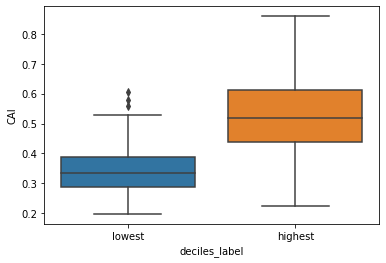

In [55]:
sns.boxplot(x='deciles_label', y='CAI', data=bins_df, order=['lowest', 'highest'])

In [56]:
expression_bins = []

for gc in bins_df['growth_correlation']:
    if gc < 0:
        expression_bins.append('neg')
    else:
        expression_bins.append('pos')

bins_df['expression_label'] = expression_bins

In [57]:
bins_df['bin_labels'] = bins_df['deciles_label'].astype(str) + '.' + bins_df['expression_label']

<AxesSubplot:xlabel='bin_labels', ylabel='CAI'>

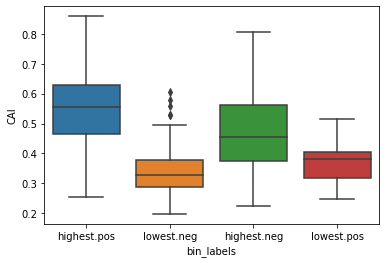

In [58]:
sns.boxplot(x='bin_labels', y='CAI', data=bins_df)